**1. Load the required libraries and read the dataset.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('renttherunway.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

**2. Check the first few samples, shape, info of the data and try to familiarize yourself with different features**

In [4]:
## lets check first few samples
df.head(2)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"


In [5]:
# checking basic information & shape about the dataframe
def basic_info(df):
    temp=df.copy(deep=True)
    print("Shape of the dataset",df.shape)
    print("*"*30)
    print(df.info())

basic_info(df)

Shape of the dataset (192544, 15)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented for      192534 non-null  object 
 7   review_text     192482 non-null  object 
 8   body type       177907 non-null  object 
 9   review_summary  192199 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
m

-> -> Shape of the dataset (192544, 15)
-> -> Data has 10 categorical and 5 numericals

**3. Check if there are any duplicate records in the dataset? If any drop them**

In [6]:
print("Total duplicates are: ", df.duplicated().sum())

Total duplicates are:  189


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
print("Total duplicates are: ", df.duplicated().sum())

Total duplicates are:  0


**4. Drop the columns which you think redundant for the analysis.(Hint drop columns like 'id', 'review')**

In [9]:
df.drop(['user_id', 'item_id', 'review_text', 'review_summary', 'review_date'],axis=1,inplace=True)
df.head(4)

,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,fit,34d,137lbs,10.0,vacation,hourglass,romper,"5' 8""",14,28.0
1,fit,34b,132lbs,10.0,other,straight & narrow,gown,"5' 6""",12,36.0
2,fit,NaN,NaN,10.0,party,NaN,sheath,"5' 4""",4,116.0
3,fit,34c,135lbs,8.0,formal affair,pear,dress,"5' 5""",8,34.0


**5. Check the column 'weight', Is there any presence of string data? If yes, remove the string data and convert to float. (Hint: 'weight' has the suffix as lbs)**

In [10]:
df['weight'].head(5)

0    137lbs
1    132lbs
2       NaN
3    135lbs
4    145lbs
Name: weight, dtype: object

In [11]:
df['weight'] = df['weight'].fillna('0').apply(lambda x: x.replace('lbs','')).astype(float)

In [12]:
df['weight'].head(5)

0    137.0
1    132.0
2      0.0
3    135.0
4    145.0
Name: weight, dtype: float64

**6. Check the unique categories for the column 'rented for' and group 'party: cocktail' category with the 'party'.**

In [13]:
df['rented for'].unique()

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', nan, 'party: cocktail'], dtype=object)

In [14]:
## grouping 'party: cocktail' category with the 'party'.
df['rented for'] = df['rented for'].str.replace('party: cocktail','party')

In [15]:
## recheck unique values after grouping
df['rented for'].unique()

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', nan], dtype=object)

**7. The column 'height' is in feet with a quotation mark, Convert to inches with float datatype.**

In [16]:
## Removing quotation marks
df['height'] = df['height'].str.replace("'",'')
df['height'] = df['height'].str.replace('"','')

In [17]:
## Converting feet to inches & converting datatype to float
df['height'] = (df['height'].str[:1].astype(float)*12 + df['height'].str[1:].astype(float))

In [18]:
df['height'].head()

0    68.0
1    66.0
2    64.0
3    65.0
4    69.0
Name: height, dtype: float64

**8. Check for missing values in each column of the dataset? If it exists, impute them with appropriate methods.**

In [19]:
df.isnull().sum()/len(df)*100

fit           0.000000
bust size     9.561488
weight        0.000000
rating        0.042110
rented for    0.005199
body type     7.603130
category      0.000000
height        0.350914
size          0.000000
age           0.499077
dtype: float64

->-> except size, category, weight and fit columns rest all columns has missing values

In [20]:
# checking for categorical and numerical variables
cat = []
num = []
for i in df.columns:
    if df[i].dtypes=='object':
        cat.append(i)
    else:
        num.append(i)
print('The categorical variables are:\n',cat,'\n')
print('The numerical variables are:\n',num)

The categorical variables are:
 ['fit', 'bust size', 'rented for', 'body type', 'category'] 

The numerical variables are:
 ['weight', 'rating', 'height', 'size', 'age']


In [21]:
## Treating numerical columns with median imputation technique.
for col in ['weight','rating','height','age']:
    df[col].fillna(df[col].median(), inplace=True)

In [22]:
## Treating categoricak columns with mode imputation technique.
for col in ['bust size','rented for','body type','category']:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [23]:
# rechecking null values
df.isnull().sum()

fit           0
bust size     0
weight        0
rating        0
rented for    0
body type     0
category      0
height        0
size          0
age           0
dtype: int64

**9. Check the statistical summary for the numerical and categorical columns and write your findings.**

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,192355.0,115.996636,53.729558,0.0,115.0,130.0,145.0,300.0
rating,192355.0,9.092709,1.429922,2.0,8.0,10.0,10.0,10.0
height,192355.0,65.309334,2.658946,54.0,63.0,65.0,67.0,78.0
size,192355.0,12.245801,8.496299,0.0,8.0,12.0,16.0,58.0
age,192355.0,33.860633,8.039386,0.0,29.0,32.0,37.0,117.0


In [25]:
df.describe(include='O').T

,count,unique,top,freq
fit,192355,3,fit,141909
bust size,192355,106,34b,45647
rented for,192355,8,wedding,57747
body type,192355,7,hourglass,69915
category,192355,68,dress,92752


-> The average weight of the customer is around 137lbs.
-> The average rating is around 9.
-> The maximum height of the customer is 78 inches.
-> The maximum standarized size of the product is 58.
-> The age range is 0 to 117.
-> Most of the customers rented the product for wedding and the most appeared product category is as dress.

**10. Is there outliers present in the column age? If yes treat them with appropriate method**

[Text(0.5, 1.0, 'Age outliers')]

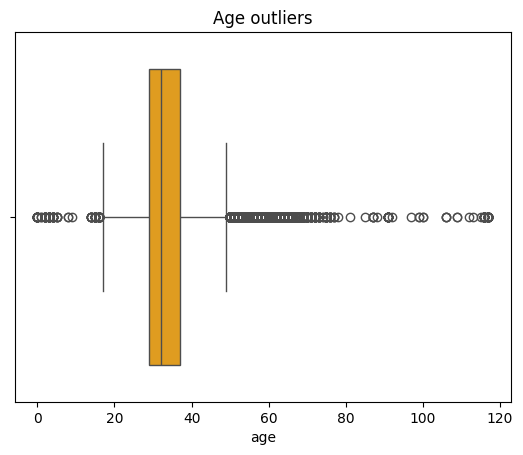

In [27]:
sns.boxplot(x='age', data=df, color='orange').set(title='Age outliers')

In [28]:
## Treating outliers in the column age using capping techinque

df['age'] = pd.DataFrame(np.where(df['age']>=100,100,df['age']))
df['age'] = pd.DataFrame(np.where(df['age']<=20,20,df['age']))

[Text(0.5, 1.0, 'Age outliers')]

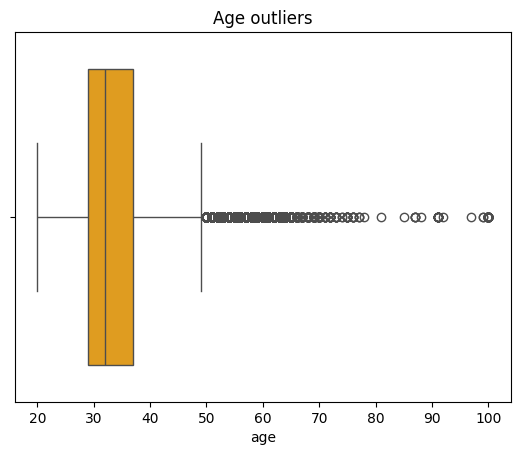

In [29]:
sns.boxplot(x='age', data=df, color='orange').set(title='Age outliers')

In [30]:
## There might be some presence of missing values in columns age, after applying capping technique.Dropping missing values
df.dropna(inplace=True)

**11. Check the distribution of the different categories in the column 'rented for' using appropriate plot.**

<Axes: >

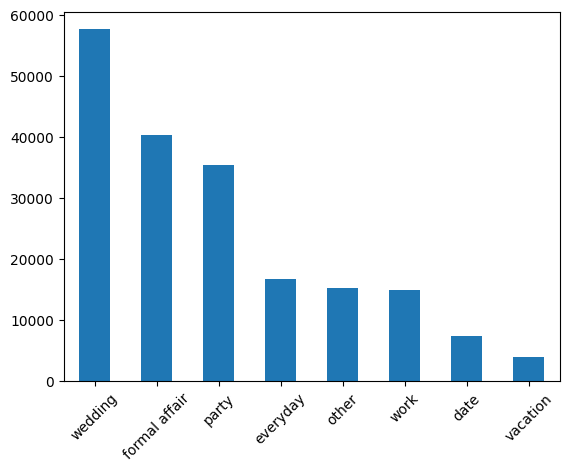

In [31]:
df['rented for'].value_counts().plot.bar(rot=45)

->-> Top 3 categories are wedding, formal affair and party.

In [32]:
dfc1 = df.copy()

**12. Encode the categorical variables in the dataset.**

In [33]:
object_type_variables = [i for i in df[cat] if df.dtypes[i] == object]
object_type_variables

le = LabelEncoder()

def encoder(df):
    for i in object_type_variables:
        q = le.fit_transform(df[i].astype(str))
        df[i] = q
        df[i] = df[i].astype(int)
encoder(df)

df = pd.get_dummies(df,drop_first=True)
df.head()

,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,0,39,137.0,10.0,5,3,44,68.0,14,28.0
1,0,37,132.0,10.0,3,6,20,66.0,12,36.0
2,0,37,0.0,10.0,4,3,45,64.0,4,100.0
3,0,38,135.0,8.0,2,4,16,65.0,8,34.0
4,0,37,145.0,10.0,6,1,20,69.0,12,27.0


**13. Standardize the data, so that the values are within a particular range.**

In [34]:
mm = MinMaxScaler()

df.iloc[:,:] = mm.fit_transform(df.iloc[:,:])
df.head()

,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,0.0,0.371429,0.456667,1.00,0.714286,0.500000,0.656716,0.583333,0.241379,0.1000
1,0.0,0.352381,0.440000,1.00,0.428571,1.000000,0.298507,0.500000,0.206897,0.2000
2,0.0,0.352381,0.000000,1.00,0.571429,0.500000,0.671642,0.416667,0.068966,1.0000
3,0.0,0.361905,0.450000,0.75,0.285714,0.666667,0.238806,0.458333,0.137931,0.1750
4,0.0,0.352381,0.483333,1.00,0.857143,0.166667,0.298507,0.625000,0.206897,0.0875


In [35]:
## Making a copy of the cleaned dataset after encoding and standardizing the columns.
dfc2 = df.copy()

**14. Apply PCA on the above dataset and determine the number of PCA components to be used so that 90-95% of the variance in data is explained by the same.**

In [36]:
## step1: Calculate the covariance matrix.
cov_matrix = np.cov(df.T)
cov_matrix

array([[ 1.26730745e-01,  3.45701617e-04,  6.81475409e-04,
        -1.55972778e-02,  8.78647447e-04, -7.07071132e-04,
         1.44511855e-05,  1.02680451e-05,  3.40946354e-03,
         6.17262942e-06],
       [ 3.45701617e-04,  1.08867149e-02,  2.01817943e-03,
        -3.93676333e-04, -5.98882983e-05, -5.91196654e-03,
        -2.18508806e-04,  1.70272658e-03,  9.58697159e-03,
         1.79219656e-05],
       [ 6.81475409e-04,  2.01817943e-03,  3.20707144e-02,
        -3.42029609e-04, -4.12699348e-05, -2.86993196e-03,
         9.60512902e-05,  1.98502361e-03,  2.29824373e-03,
        -3.71829233e-05],
       [-1.55972778e-02, -3.93676333e-04, -3.42029609e-04,
         3.19574727e-02,  6.63820980e-04,  2.22987872e-04,
        -8.05529964e-04,  3.50561318e-05, -9.61954298e-04,
         4.54908867e-06],
       [ 8.78647447e-04, -5.98882983e-05, -4.12699348e-05,
         6.63820980e-04,  8.65633768e-02, -7.05120242e-04,
        -3.23050298e-03, -5.60041470e-04,  2.13246115e-04,
        -1.

In [37]:
## step2: Calculate the eigen values and eigen vectors.
eig_vals, eig_vectors = np.linalg.eig(cov_matrix)
print('eigein vals:','\n',eig_vals)
print('\n')
print('eigein vectors','\n',eig_vectors)

eigein vals: 
 [0.12939155 0.08680199 0.07175672 0.03630785 0.03273595 0.02936262
 0.02448546 0.00514172 0.01116837 0.00987401]


eigein vectors 
 [[ 9.86377806e-01  1.65763786e-02  2.62250262e-02 -1.83478453e-02
   3.06328605e-02 -1.56575288e-01  1.18622918e-02 -1.22139071e-02
  -3.94494324e-03  4.87683463e-05]
 [ 7.31067157e-03 -3.39193122e-03 -1.28876338e-01 -1.20706583e-02
  -1.55531749e-01  2.39106758e-02 -4.40072087e-01 -8.55399812e-01
   1.81295285e-01 -1.33465956e-02]
 [ 9.01122473e-03 -1.28827901e-03 -9.10451826e-02  1.10917637e-02
  -9.31838770e-01 -1.21002443e-01  3.23881654e-01  2.47209793e-02
   5.50366551e-02  5.60881047e-04]
 [-1.58229972e-01 -1.73786258e-02  2.51827252e-03 -1.04631742e-01
   9.58051565e-02 -9.73564713e-01 -8.11742502e-02 -8.26606515e-04
   1.04707442e-02 -8.11326737e-04]
 [ 1.81510706e-02 -9.96730757e-01  4.20453883e-02  6.54236562e-02
  -4.09670961e-03  7.62687691e-03 -2.31234721e-03 -2.66963979e-03
  -7.73861833e-03  1.71897213e-03]
 [-1.83089569e-02 

In [38]:
## step3: Scree plot.
total = sum(eig_vals)
var_exp = [(i/total)*100 for i in sorted(eig_vals,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('Explained Variance: ',var_exp)
print('Cummulative Variance Explained: ',cum_var_exp)

Explained Variance:  [29.60727288426113, 19.861963436221906, 16.419317176937547, 8.307933253320297, 7.49061338898316, 6.718732400482873, 5.602743504706044, 2.5555372266091982, 2.2593621638469092, 1.1765245646309441]
Cummulative Variance Explained:  [ 29.60727288  49.46923632  65.8885535   74.19648675  81.68710014
  88.40583254  94.00857604  96.56411327  98.82347544 100.        ]


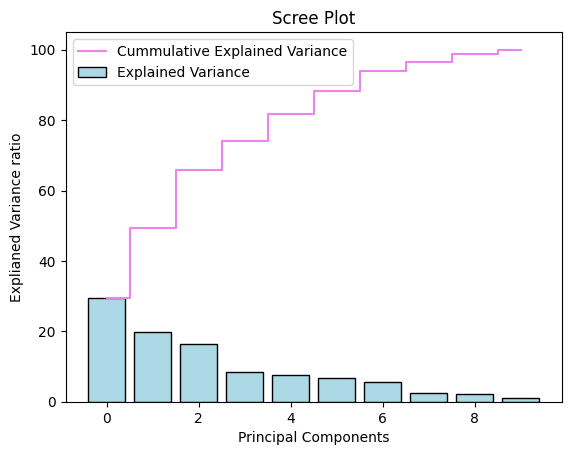

In [39]:
## Scree plot.
plt.bar(range(10),var_exp,align='center',color='lightblue',edgecolor='black',label='Explained Variance')
plt.step(range(10),cum_var_exp,where='mid',color='violet',label='Cummulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explianed Variance ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.show()

-> We can observe from the above scree plot the first 6 principal components are explaining the about 90-95% of the variation,
So we can choose optimal number of principal components as 6.

**15. Apply K-means clustering and segment the data (You may use original data or PCA transformed data)**

In [40]:
pca = PCA(n_components=6)

pca_df = pd.DataFrame(pca.fit_transform(df),columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.208520,-0.136587,0.015947,0.298330,0.077493,-0.117360
1,-0.224811,0.146155,-0.473181,-0.075024,0.128530,-0.079133
2,-0.221648,0.009295,-0.068099,0.303012,-0.412687,-0.070920
3,-0.184123,0.275429,-0.159903,-0.115788,0.087036,0.164319
4,-0.201149,-0.315370,0.326372,-0.046572,0.046507,-0.085961


->-> These are the new dimensions obtained from the application of PCA.

In [41]:
## finding optimal K value by KMeans clustering using Elbow plot.
cluster_errors = []
cluster_range = range(2,15)
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters,random_state=100)
    clusters.fit(pca_df)
    cluster_errors.append(clusters.inertia_)

In [42]:
## creataing a dataframe of number of clusters and cluster errors.
cluster_df = pd.DataFrame({'num_clusters':cluster_range,'cluster_errors':cluster_errors})

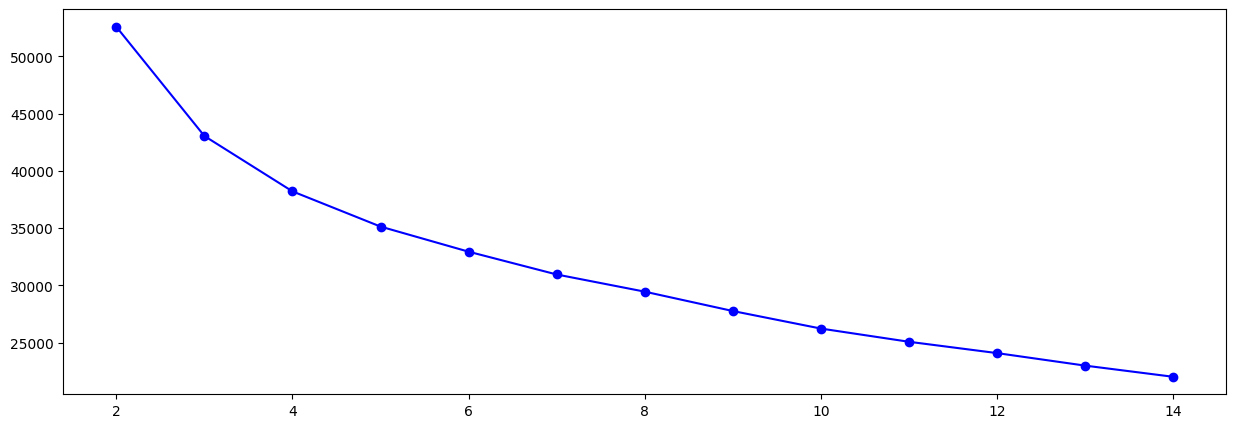

In [43]:
## Elbow plot.
plt.figure(figsize=[15,5])
plt.plot(cluster_df['num_clusters'],cluster_df['cluster_errors'],marker='o',color='b')
plt.show()

->-> From the above elbow plot we can see at the cluster K=3, the inertia significantly decreases . Hence we can select our optimal clusters as K=3.

In [44]:
kmeans = KMeans(n_clusters=3, random_state=100)
kmeans.fit(pca_df)

KMeans(n_clusters=3, random_state=100)

In [45]:
## creating a dataframe of the labels.
label = pd.DataFrame(kmeans.labels_,columns=['Label'])

In [46]:
## joining the label dataframe to the pca_df dataframe.
kmeans_df = pca_df.join(label)
kmeans_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Label
0,-0.208520,-0.136587,0.015947,0.298330,0.077493,-0.117360,1
1,-0.224811,0.146155,-0.473181,-0.075024,0.128530,-0.079133,0
2,-0.221648,0.009295,-0.068099,0.303012,-0.412687,-0.070920,1
3,-0.184123,0.275429,-0.159903,-0.115788,0.087036,0.164319,0
4,-0.201149,-0.315370,0.326372,-0.046572,0.046507,-0.085961,1


In [47]:
kmeans_df['Label'].value_counts()

1    82498
0    65761
2    43718
Name: Label, dtype: int64

In [48]:
## finding optimal clusters through silhoutte score
from sklearn.metrics import silhouette_score
for i in range(2,15):
    kmeans = KMeans(i,random_state=100)
    kmeans.fit(pca_df)
    labels = kmeans.predict(pca_df)
    print(i,silhouette_score(pca_df,labels))

2 0.33337928368485775
3 0.24182088752204384
4 0.23341599236983887
5 0.22041624801280282
6 0.18909790174783364
7 0.19753928220867797
8 0.20669995174045594
9 0.21567255178991657
10 0.22037478197008237
11 0.22171830969325243
12 0.21026965335068956
13 0.21409049729761426
14 0.2357464251375346


->-> Above from elbow plot we chose optimal K value as 3 and we built a Kmeans clustering model.
->->  From the silhoutte score we can observe the for clusters 2 and 3 the score is higher. We can build Kmeans clustering model using the optimal K value as either 2 or 3.

**16. Apply Agglomerative clustering and segement the data. (You may use original data or PCA transformed data)**
a. Find the optimal K Value using dendrogram for Agglomerative clustering.
b. Build a Agglomerative clustering model using the obtained optimal K value from observed from dendrogram.
c. Compute silhoutte score for evaluating the quality of the Agglomerative clustering technique.
(Hint: Take a sample of the dataset for agglomerative clustering)

## Let us use the dfc2 for this (a copy of the cleaned dataset after encoding and data standardization)
## Since dataset is huge plotting dendrogram might be time consuming.
## Let us take a sample of the dataset. (since the dataset is huge around 2 lakh rows, let take a sample)


In [49]:
## Taking a sample of 50K rows from the dfc2 dataframe using random sampling technique provided by pandas

## Storing it in the new dataframe called 'dfc3'
dfc3 = dfc2.sample(n=50000)

## reseting the index
dfc3.reset_index(inplace=True,drop=True)

In [50]:
dfc3.head(4)

,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,0.0,0.352381,0.38,0.75,0.285714,1.000000,0.298507,0.375000,0.137931,0.1000
1,0.0,0.380952,0.50,0.75,0.285714,0.500000,0.298507,0.458333,0.275862,0.1625
2,0.0,0.228571,0.34,1.00,0.428571,0.833333,0.238806,0.208333,0.017241,0.1125
3,0.0,0.457143,0.42,0.75,0.000000,0.666667,0.238806,0.458333,0.137931,0.0875


**Dendrogram**